Cross-Validation Scores: [0.72081218 0.74365482 0.74045802 0.72010178 0.69720102]
Average Cross-Validation Accuracy: 0.7244455638651012
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.74      0.71      0.72       246
           1       0.72      0.75      0.74       246

    accuracy                           0.73       492
   macro avg       0.73      0.73      0.73       492
weighted avg       0.73      0.73      0.73       492

Feature Importances:
  Feature  Importance
0     PTS    0.395828
1     REB    0.248730
2     AST    0.196619
3     STL    0.158823


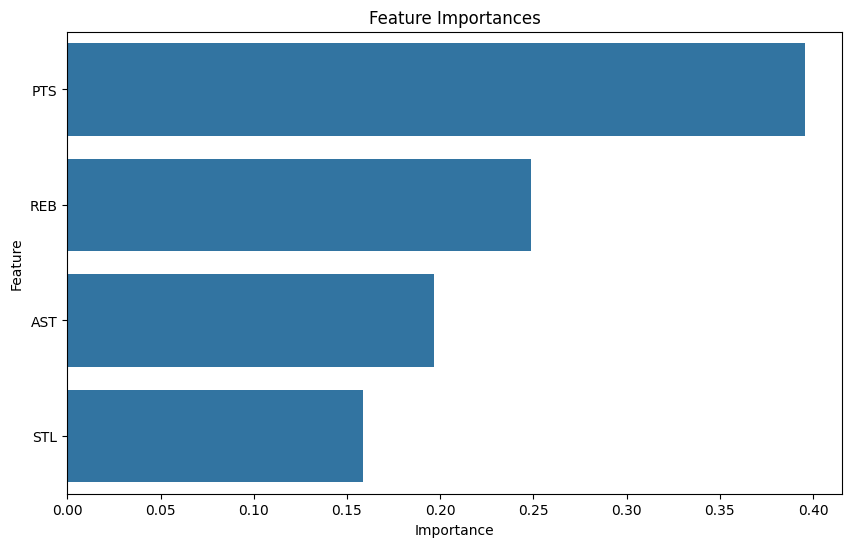

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

data = pd.read_excel("Dataset.xlsx")

# data preprocessing
data["W/L"] = data["W/L"].map({"W": 1, "L": 0})
data["FT%"] = pd.to_numeric(data["FT%"], errors="coerce")
data = data.dropna()

# features
data["PTS_REB"] = data["PTS"] * data["REB"]
# interaction between points and rebounds
data["AST_STL"] = data["AST"] * data["STL"]
# interaction between assists and steals
data["Rolling_PTS_Mean"] = data.groupby("Team")["PTS"].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
# rolling points average across last three games
data["Rolling_REB_Mean"] = data.groupby("Team")["REB"].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
# rolling rebounds average across last three games

# scaling
scaler = StandardScaler()
numeric_features = data.select_dtypes(include=["number"]).columns.drop("W/L")
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# simplified dataset
key_features = ["PTS", "REB", "AST", "STL"]  # +/- was source of wonky accuracy metrics in the other notebook
X = data[key_features]
y = data["W/L"]

# training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# train the RF model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# cross validation
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="accuracy")
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Accuracy:", cv_scores.mean())

# evaluation on test set
y_pred = rf.predict(X_test)
classification_report_rf = classification_report(y_test, y_pred)
print("Classification Report (Test Set):")
print(classification_report_rf)

# feature importances
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)
print("Feature Importances:")
print(feature_importances)

# feature importances bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances)
plt.title("Feature Importances")
plt.show()
